In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sqlalchemy import create_engine
from sklearn import linear_model
import seaborn as sns
from scipy.stats.mstats import winsorize

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather = pd.read_sql_query('select * from weatherinszeged',con=engine)

engine.dispose()

weather.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.


### Data Cleaning

In [122]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [109]:
weather.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,10.855,0.735,10.811,187.509,10.347,0.000,1003.236
std,9.552,10.697,0.195,6.914,107.383,4.192,0.000,116.970
min,-21.822,-27.717,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.689,2.311,0.600,5.828,116.000,8.340,0.000,1011.900
50%,12.000,12.000,0.780,9.966,180.000,10.046,0.000,1016.450
75%,18.839,18.839,0.890,14.136,290.000,14.812,0.000,1021.090
max,39.906,39.344,1.000,63.853,359.000,16.100,0.000,1046.380


Pressure and humidity can not be zero. These records are wrong

In [123]:
len(weather.loc[(weather['pressure'] == 0) | (weather['humidity'] == 0)])

1310

Since the rows with zero value in both columns represnt 1.36% of the 96453 rows available in the data. dropping these values could be a viable option

In [124]:
weather_df = weather.loc[weather['pressure'] != 0]
weather_df = weather_df.loc[weather['humidity'] != 0]

In [125]:
total_missing = weather_df.isnull().sum().sort_values(ascending=False)
percent_missing = (weather_df.isnull().sum()/weather_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
dailysummary,0,0.000
pressure,0,0.000
loudcover,0,0.000
visibility,0,0.000
windbearing,0,0.000
windspeed,0,0.000
humidity,0,0.000
apparenttemperature,0,0.000
temperature,0,0.000
preciptype,0,0.000


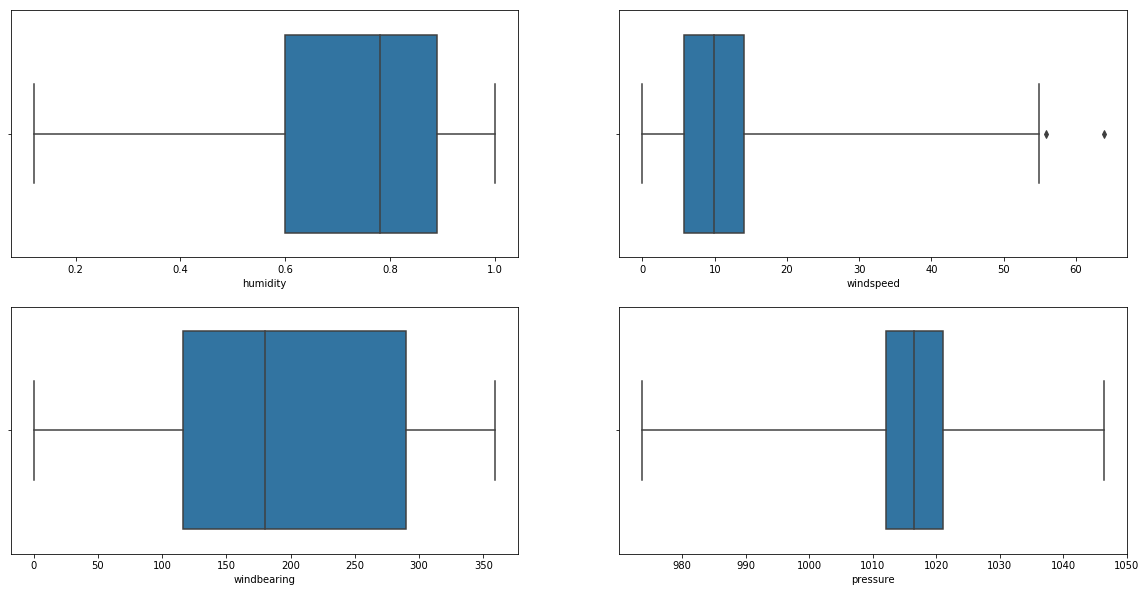

In [126]:
plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
sns.boxplot(weather_df["humidity"], whis = 5)

plt.subplot(2,2,2)
sns.boxplot(weather_df["windspeed"], whis = 5)

plt.subplot(2,2,3)
sns.boxplot(weather_df["windbearing"], whis = 5)

plt.subplot(2,2,4)
sns.boxplot(weather_df["pressure"], whis = 5)
plt.show()

wind speed has 2 outliers. the data will be winsorized 

In [127]:
weather_df['windspeed_win'] = winsorize(weather_df['windspeed'], (0.10, 0.10))

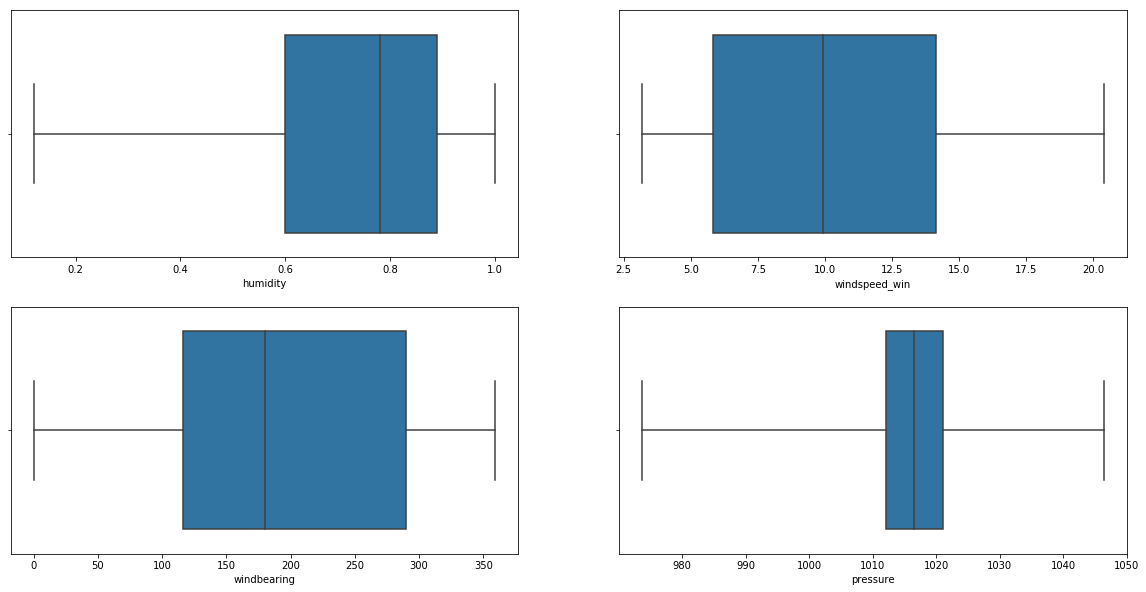

In [128]:
plt.figure(figsize = (20,10))

plt.subplot(2,2,1)
sns.boxplot(weather_df["humidity"], whis = 5)

plt.subplot(2,2,2)
sns.boxplot(weather_df["windspeed_win"], whis = 5)

plt.subplot(2,2,3)
sns.boxplot(weather_df["windbearing"], whis = 5)

plt.subplot(2,2,4)
sns.boxplot(weather_df["pressure"], whis = 5)
plt.show()

Data is clean with no outliers now and ready ro go !!!!

### Model

In [129]:
Y = weather_df['temperature']
X = weather_df[['humidity', 'windspeed_win', 'windbearing', 'pressure']]

lrm = linear_model.LinearRegression()
lrm.fit(X, Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.29300270e+01 -3.79731195e-01  2.03088808e-03 -4.11136560e-01]

Intercept: 
 457.7718706825645


### Assumption one: linearity of the model in its coefficients

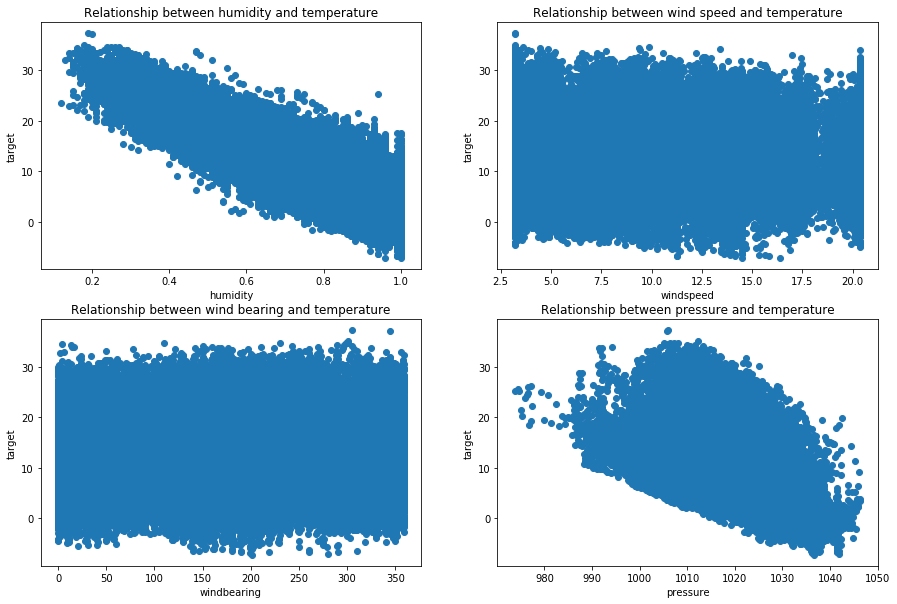

In [148]:
lrm_model = linear_model.LinearRegression()
lrm_model.fit(weather_df[['humidity', 'windspeed_win', 'windbearing', 'pressure']], weather_df['temperature'])
predictions = lrm_model.predict(weather_df[['humidity', 'windspeed_win', 'windbearing', 'pressure']])

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.scatter(weather_df['humidity'], predictions)
plt.xlabel("humidity")
plt.ylabel("target")
plt.title('Relationship between humidity and temperature')

plt.subplot(2,2,2)
plt.scatter(weather_df['windspeed_win'], predictions)
plt.xlabel("windspeed")
plt.ylabel("target")
plt.title('Relationship between wind speed and temperature')

plt.subplot(2,2,3)
plt.scatter(weather_df['windbearing'], predictions)
plt.xlabel("windbearing")
plt.ylabel("target")
plt.title('Relationship between wind bearing and temperature')

plt.subplot(2,2,4)
plt.scatter(weather_df['pressure'], predictions)
plt.xlabel("pressure")
plt.ylabel("target")
plt.title('Relationship between pressure and temperature')
plt.show()

The model captured the linear relationship between target variable and the features

### Assumption two: the error term should be zero on average

In [149]:
predictions = lrm.predict(weather_df[['humidity', 'windspeed_win', 'windbearing', 'pressure']])
errors = Y - predictions

print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))

Mean of the errors in the temperature model is: 1.722690672691485e-14


Since, we include the constant term in the model, the average of the model's error is effectively zero.

### Assumption three: homoscedasticity

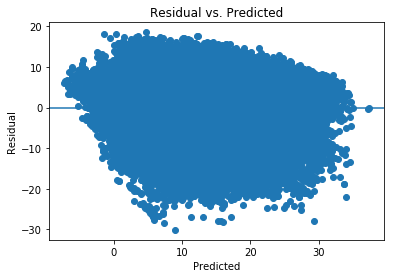

In [150]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [151]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 305.302 and p value is 2.3e-68
Levene test statistic value is 206.561 and p value is 8.18e-47


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

### Assumption four: low multicollinearity

In [152]:
weather_df[['humidity', 'windspeed_win', 'windbearing', 'pressure']].corr()

,humidity,windspeed_win,windbearing,pressure
humidity,1.000,-0.234,0.001,0.041
windspeed_win,-0.234,1.000,0.083,-0.249
windbearing,0.001,0.083,1.000,-0.078
pressure,0.041,-0.249,-0.078,1.000


Multicollinearity is low between the variables. most of them are exremely low. the only exception is a correlation of -0.234 between windspeed and humidity and -0.249 windspeed and pressure which are considered low as well.

### Assumption five: error terms should be uncorrelated with one another

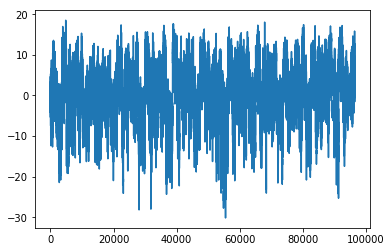

In [153]:
plt.plot(errors)
plt.show()

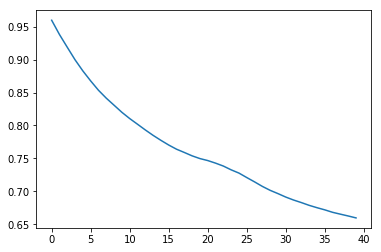

In [154]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

It seems that the error terms of our model are uncorrelated with each other, the autocorrelation between the errors of temperature model is relatively high (ranging between 0.65 and 0.95).

### Assumption six: features shouldn't be correlated with the errors

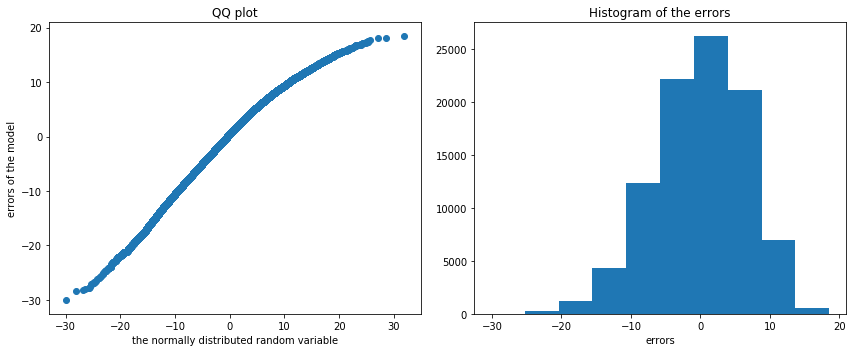

In [155]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [156]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 2228.1122083006367 and p value is 0.0
Normality test statistics is 2091.3202976134958 and p value is 0.0


Errors are not normally distributed exactly. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

The p-values of both tests indicate that our errors are not normally distributed.